In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from util.cifar10_loader import Cifar10Loader
from util.data_visualizer import DataVisualizer

### Load and Visualize CIFAR 10 Data into train, test

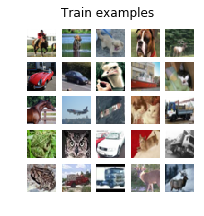

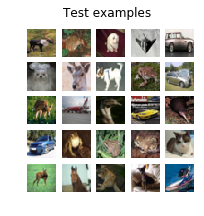

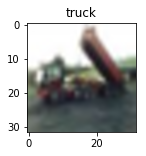

In [2]:
model_path = './models'
data_loader = Cifar10Loader()
dv = DataVisualizer()

X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar, labels = data_loader.load_cifar10('./Datasets/cifar-10')

# data_visualizer expects unflatted images
dv.visualize_data(X_train_cifar, 'Train examples')
dv.visualize_data(X_test_cifar, 'Test examples')

# Flatten data
X_train_cifar = X_train_cifar.reshape(X_train_cifar.shape[0], -1)
X_test_cifar = X_test_cifar.reshape(X_test_cifar.shape[0], -1)

# Verify Flattened data
image_id = 2
dv.visualize_image(X_train_cifar[image_id].reshape(32, 32, 3), labels[y_train_cifar[image_id]])

# Utilities

In [3]:
from scipy.special import expit

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_alternate(x):
    return expit(x)

# Division by Std dev not needed as the initial image is already in range of 0 to 1 
# due to earlier division by 255. So now all the different features (pixels) are in similar scale.
def scale_features(X, X_mean=None, X_std=None, divide_by_std_dev=False, view_hists=False):
    if X_mean is None:
        X_mean = np.mean(X, axis=0)
    if X_std is None:
        X_std = np.std(X, axis=0)
    X_1 = X - X_mean
    X_2 = X_1/X_std

    if view_hists == True:
        fig, axes1 = plt.subplots(3,1,figsize=(7,7))
        plt.suptitle('Histogram of 0th pixel of all examples')
        axes1[0].set_title('data')
        axes1[0].hist(X[:,0])
        axes1[1].set_title('data - Mean(data)')
        axes1[1].hist(X_1[:,0])
        axes1[2].set_title('(data - Mean(data))/Std_dev(data)')
        axes1[2].hist(X_2[:,0])

    if divide_by_std_dev is True:
        return X_2, X_mean, X_std
    else:
        return X_1, X_mean, X_std

def append_ones(X):
    return np.concatenate((X, np.ones((X.shape[0], 1), dtype=int)), axis=1)

def generate_binary_classification_label_from_multiclass_labels(labels, num_classes):
    # Generate 10 sets of labels for each class
    binary_labels = np.zeros((10, labels.shape[0]), dtype=int)
    for i in range(num_classes):
        binary_labels[i] = (labels == i)
    return binary_labels

# Softmax Classification

### Learnings:


### TODO:

In [4]:
import time

class SoftmaxClassification():
    def __init__(self, verbose=True):
        self.weights = None
        self.verbose = verbose
        self.loss_list = []
        self.accuracy_list = []
        self.val_accuracy_list = []
        self.val_loss_list = []
        
    def _initialize_weights(self):
        self.loss_list = []
        self.accuracy_list = []
        self.val_accuracy_list = []  
        self.val_loss_list = []
        # define weights - random from uniform distribution over [0,1] or initialize to 0?
        self.weights = np.random.rand(self.num_classes, self.num_features)/self.num_train_data

    def _plot(self, list1, label1, list2=None, label2=None, title='Plot'):
        plt.figure()
        plt.title(title)
        plt.plot(list1, 'r', label=label1)
        if list2 is not None and list2 is not []:
            plt.plot(list2, 'b', label=label2)
        plt.legend()

    def _forward_propagate(self, X):
        f = np.dot(X, self.weights.T)
        # To ensure exponentials don't blow up
        y_score = np.exp(f - np.max(f, axis=1).reshape(-1, 1))
        # y_scores will have "probabilities" (in range of 0 to 1)
        y_score = y_score / np.sum(y_score, axis=1).reshape(-1, 1)
        y_pred = np.argmax(y_score, axis=1).astype(int)
        return y_score, y_pred
    
    def _compute_loss(self, y, y_score):
        softmax = y_score[np.arange(y_score.shape[0]), y]
        loss_cross_entropy = np.sum(-np.log(softmax))/y.shape[0]
        return loss_cross_entropy
    
    def _compute_loss_derivative(self, X, y, y_score):
        y_score[np.arange(y_score.shape[0]), y] -= 1
        loss_derivative = np.dot(y_score.T, X)
        return loss_derivative

    def _update_weights(self, loss_derivative):
        self.weights = self.weights - (self.learning_rate / self.num_train_data) * loss_derivative
        
    def train(self, X, y, num_epochs, X_val=None, y_val=None, learning_rate=0.01, initialize_weights=False, 
              gradient_descent_type='batch', enable_regularization=False, regularization_rate=0.1):
        """
        Train the classifier
        Parameters
        ----------
        X: (N x M) nd-array of dtype=float where N is the size of train dataset, M is the number of features
        y: (N x 1) nd-array of dtype=int where N is the size of train dataset
        """
        self.num_train_data = X.shape[0]
        self.num_features = X.shape[1]
        self.num_classes = np.unique(y).shape[0]
        self.learning_rate = learning_rate
        if self.num_train_data != y.shape[0]:
            raise ValueError("Train Data size and Label size don't match")

        if self.weights is None or initialize_weights is True:
            self._initialize_weights()

        for i in range(num_epochs):

            y_score, y_pred = self._forward_propagate(X)
            loss_cross_entropy = self._compute_loss(y, y_score)
            acc = self.get_accuracy(y, y_pred)

            if X_val is not None:
                y_val_score, y_val_pred = self._forward_propagate(X_val)
                val_loss_cross_entropy = self._compute_loss(y_val, y_val_score)
                val_acc = self.get_accuracy(y_val, y_val_pred)

            if enable_regularization is True:
                # Don't include bias while summing up weights
                regularization_penalty = regularization_rate * np.sum(np.square(self.weights[:,:-1]))
                loss_cross_entropy = loss_cross_entropy + regularization_penalty
                if X_val is not None:
                    val_loss_cross_entropy = val_loss_cross_entropy + regularization_penalty
            
            # Back Propagation
            loss_derivative = self._compute_loss_derivative(X, y, y_score)
            self._update_weights(loss_derivative)

            if enable_regularization is True:
                self.weights = self.weights - (learning_rate * regularization_rate)*self.weights

            self.loss_list.append(loss_cross_entropy)
            self.accuracy_list.append(acc)
            if X_val is not None:
                self.val_accuracy_list.append(val_acc)
                self.val_loss_list.append(val_loss_cross_entropy)
            
            if self.verbose is True and i%100 == 0:
                print('Iteration {}: Accuracy = {} Loss = {}'.format(i, acc, loss_cross_entropy))

        self._plot(self.loss_list, 'Training Loss', self.val_loss_list, 'Validation Loss', 
                   title='Training and Validation Loss')
        self._plot(self.accuracy_list, 'Training Accuracy', self.val_accuracy_list, 'Validation Accuracy', 
                   title='Training and Validation Accuracy')
        
    def predict(self, X):
        _, y_pred = self._forward_propagate(X)
        return y_pred
    
    def get_accuracy(self, y_ground_truth, y_predicted):
        """
        Computes accuracy
        Parameters
        ----------
        y_ground_truth: (N x 1) nd-array of dtype=int
        y_predicted: (N x 1) nd-array of dtype=int
        Returns:
        accuracy of type float
        """
        return(100*np.mean(y_predicted == y_ground_truth))
    
    def save_model(self, filename):
        np.save(filename, self.weights)

    def load_model(self, filename):
        self.weights = np.load(filename)

    def visualize_weights(self, label_names):
        fig, axes1 = plt.subplots(10,1,figsize=(20,20))
        plt.suptitle('Weights')
        print("Bias = ", self.weights[:,-1])
        for i, weight_image in enumerate(self.weights):
            weight_image = weight_image[:-1].reshape(32, 32, 3)
            axes1[i].set_title(label_names[i])
            axes1[i].imshow(weight_image)

### Generate Correct Features and Labels

In [5]:
def preprocess_features(train_features, test_features, divide_by_std_dev=True):
    X_train, X_mean, X_std = scale_features(train_features, divide_by_std_dev=divide_by_std_dev, view_hists=False)
    X_train = append_ones(X_train)

    X_test,_,_ = scale_features(test_features, X_mean=X_mean, X_std=X_std, divide_by_std_dev=divide_by_std_dev, view_hists=False)
    X_test = append_ones(X_test)
    return X_train, X_test

def get_binary_labels_for_class(train_labels, test_labels, class_id):
    train_labels_binary = generate_binary_classification_label_from_multiclass_labels(train_labels, 10)
    y_train = train_labels_binary[class_id].reshape(-1, 1)

    test_labels_binary = generate_binary_classification_label_from_multiclass_labels(test_labels, 10)
    y_test = test_labels_binary[class_id].reshape(-1, 1)
    return y_train, y_test

### Split training into training and validation data

In [6]:
def split_train_validation_data(X, y, split=0.8):
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    X_train = X[indexes[:int(split*X.shape[0])]]
    y_train = y[indexes[:int(split*X.shape[0])]]    
    X_val = X[indexes[int(split*X.shape[0]):]]
    y_val = y[indexes[int(split*X.shape[0]):]]    
    return X_train, y_train, X_val, y_val

## Experiment 1

Iteration 0: Accuracy = 9.3125 Loss = 2.3025803668795635
Iteration 100: Accuracy = 39.9375 Loss = 1.7952545292553708
Iteration 200: Accuracy = 41.195 Loss = 1.7741489040184004
Iteration 300: Accuracy = 41.7525 Loss = 1.7669618928430677
Iteration 400: Accuracy = 42.1875 Loss = 1.7642314918131707
Iteration 500: Accuracy = 42.5425 Loss = 1.763401750840427
Iteration 600: Accuracy = 42.7425 Loss = 1.7634563479986478
Iteration 700: Accuracy = 42.93 Loss = 1.7639289269868037
Iteration 800: Accuracy = 43.035000000000004 Loss = 1.764588904668634
Iteration 900: Accuracy = 43.1325 Loss = 1.7653170114077001
Iteration 1000: Accuracy = 43.2475 Loss = 1.7660501767359766
Iteration 1100: Accuracy = 43.322500000000005 Loss = 1.7667551909487742
Iteration 1200: Accuracy = 43.395 Loss = 1.7674153259053071
Iteration 1300: Accuracy = 43.4725 Loss = 1.7680231827929003
Iteration 1400: Accuracy = 43.522499999999994 Loss = 1.7685767035110218
Iteration 1500: Accuracy = 43.5525 Loss = 1.7690768699092587
Iteration 

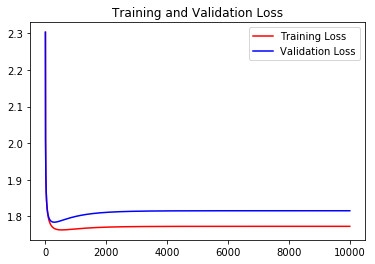

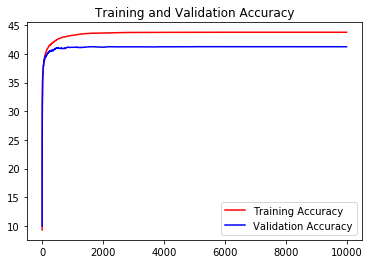

In [7]:
X_train, X_test = preprocess_features(X_train_cifar, X_test_cifar, divide_by_std_dev=True)
y_train, y_test = y_train_cifar, y_test_cifar
X_train, y_train, X_val, y_val = split_train_validation_data(X_train, y_train, split=0.8)

num_epochs = 10000
sm = SoftmaxClassification()
sm.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, 
         enable_regularization=True, regularization_rate=0.1)

Accuracy on Training data = 43.7775  (186621)
Accuracy on Test data = 41.42  (46381)
Bias =  [-0.04746443 -0.04699979  0.09938397  0.07390327  0.04538866  0.04105129
 -0.0389663   0.04050482 -0.10050714 -0.06629435]


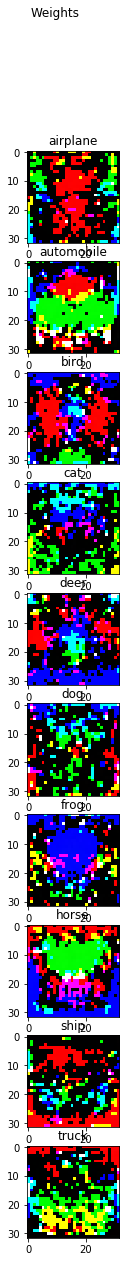

In [8]:
model_file = "softmax_classification_cifar10_epochs{}_{}.npy".format(num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
sm.save_model(model_file)

y_pred = sm.predict(X_train)
print("Accuracy on Training data = {}".format(sm.get_accuracy(y_train, y_pred)))

y_pred = sm.predict(X_test)
print("Accuracy on Test data = {}".format(sm.get_accuracy(y_test, y_pred)))

sm.visualize_weights(labels)

Iteration 0: Accuracy = 43.7775 Loss = 1.7731197783316142
Iteration 100: Accuracy = 43.7775 Loss = 1.7731198055831452
Iteration 200: Accuracy = 43.7775 Loss = 1.7731198300350448
Iteration 300: Accuracy = 43.7775 Loss = 1.7731198519765312
Iteration 400: Accuracy = 43.7775 Loss = 1.773119871666754
Iteration 500: Accuracy = 43.7775 Loss = 1.7731198893379454
Iteration 600: Accuracy = 43.7775 Loss = 1.7731199051982323
Iteration 700: Accuracy = 43.7775 Loss = 1.7731199194341605
Iteration 800: Accuracy = 43.7775 Loss = 1.7731199322129436
Iteration 900: Accuracy = 43.7775 Loss = 1.7731199436844824
Iteration 1000: Accuracy = 43.7775 Loss = 1.7731199539831692
Iteration 1100: Accuracy = 43.7775 Loss = 1.7731199632295032
Iteration 1200: Accuracy = 43.7775 Loss = 1.773119971531532
Iteration 1300: Accuracy = 43.7775 Loss = 1.7731199789861531
Iteration 1400: Accuracy = 43.7775 Loss = 1.7731199856802657
Iteration 1500: Accuracy = 43.7775 Loss = 1.7731199916918112
Iteration 1600: Accuracy = 43.7775 Los

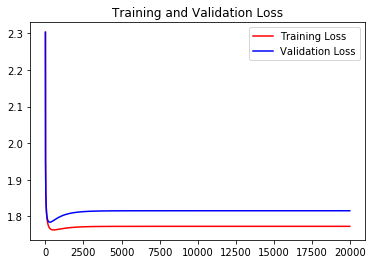

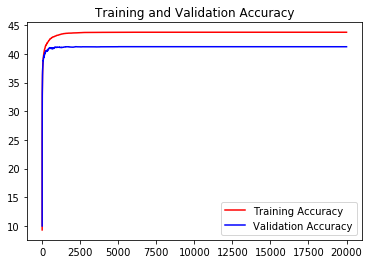

In [9]:
sm.train(X_train, y_train, num_epochs=num_epochs, X_val=X_val, y_val=y_val, learning_rate=0.01, 
         enable_regularization=True, regularization_rate=0.1)
total_epochs=2*num_epochs

Accuracy on Training data = 43.7775  (186621)
Accuracy on Test data = 41.42  (46381)
Bias =  [-0.04746444 -0.04699981  0.099384    0.07390331  0.0453887   0.04105133
 -0.03896632  0.04050483 -0.10050721 -0.06629439]


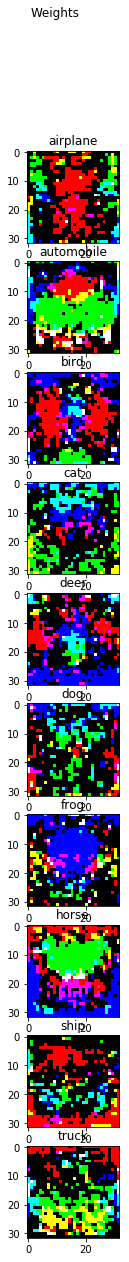

In [10]:
model_file = "softmax_classification_cifar10_epochs{}_{}.npy".format(total_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
sm.save_model(model_file)

y_pred = sm.predict(X_train)
print("Accuracy on Training data = {}".format(sm.get_accuracy(y_train, y_pred)))

y_pred = sm.predict(X_test)
print("Accuracy on Test data = {}".format(sm.get_accuracy(y_test, y_pred)))

sm.visualize_weights(labels)

In [11]:
print(y_pred)

[3 9 8 ..., 3 5 7]
